# Where are the mistakes? Spot the Error and win, D & R.

Here I shall put all the calculations and simulations for the 3D case, one after the other, so that you can try to see what is wrong. Or that we hit the jackpot.

## Volume:

The Box has three dimensions, $h_1, h_2, h_3$. We shall use similar shorthand notation for the "avaible axis lengths", in the manner $a=h_1/2-r, b=h_2/2-r,c=h_3/2-r$.

The Volume of the 3D box has, like before, a "positive" part, that doesn't take into account the exclusion condition, and a negative part, which is the set for where the balls would overlap:
$$V=V_{pos}-V_{neg}$$
$$V_{pos}=64a^2b^2c^2$$
  $$\frac{V_{neg}}{64}= 8 \bigg(
   r^3 a_1 a_2 a_3 \frac{\pi}{6}
  - r^4/4 \frac{\pi}{4} (a_1 a_2 +a_2 a_3 + a_3 a_1)
  +  r^5/20 (a_1 + a_2 + a_3)
  -  r^6/48 \bigg).
$$

So, let us start then with the numerics in this  place right here right now. Notice that I have put some extra results in the functions, as to compare the "negative" part alone. This is so because the the positive part can overshadow the negative part. We could see the errors much more evidently if only the negative part is present, specially if its very small compared with the positive part.

In [1]:
using Distributions, Plots

h1 = 1.0
h2 = 1.5
h3 = 1.75
rpmax=minimum([h1,h2,h3])/4 # discontinuity in the derivatives limiting radius.
sr2= sqrt(2)


┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


1.4142135623730951

In [2]:

volPos(a1, a2, a3) = 64 *a1^2*a2^2*a3^2
volNeg(a1, a2, a3, r) = 64* ( (sr2*r)^3*π/6*a1*a2*a3*sr2^3
                            -(sr2*r)^4/16*π*(a1*a2+a2*a3+a3*a1)*sr2^2
                            +(sr2*r)^5/15*(a1+a2+a3)*sr2
                            -(sr2*r)^6/48)


# The neg volume is much much smaller than the full box
# in order to appreciate errors, we shall thest ONLY the neg volume
function vol(a, b, c, r)
    resulttotal = volPos(a, b, c) - volNeg(a, b, c, r)
    resultneg =  volNeg(a, b, c, r)
    
    return (resulttotal, resultneg)
end 

vol (generic function with 1 method)

In [3]:
"Available volume in configuration space"
function MC_volume(a, b, c, r, N=10^7)

    validtrue = 0
    validneg=0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        ## Test ONLY negated Volume, not avaible Volume
        if (x1-x2)^2 + (y1-y2)^2 +(z1-z2)^2  > (2r)^2  # non-overlapping condition
            validtrue += 1
        else
            validneg += 1
        end
    end
    
    
    p = validtrue / N
    pneg = validneg /N
    σ² = p * (1 - p) / N   # estimated variance of binomial distribution
    σ = √(σ²)
    vbox=volPos(a,b,c)
    
    return ( vbox * p,  vbox*pneg, vbox * σ )
    
end

MC_volume

### Generic MonteCarlo Meta routine

In [4]:
function run_MC(MC_func, exact_func, rmax, N=10^6)
    h1, h2, h3 = 1.5, 1.2, 1

    numerical_total = Float64[]
    numerical_neg = Float64[]
    sigma_data = Float64[]  # standard deviation
    exact_total = Float64[]
    exact_neg = Float64[]
    
    rs = Float64.(0.01:0.005:rmax)

    for r in rs

        print(r, " ")

        a = h1/2 - r
        b = h2/2 - r
        c=  h3/2 -r
        
        μtotal, μneg, σ =  MC_func(a, b, c, r, N)

        push!(numerical_total, μtotal)
        push!(numerical_neg, μneg)
        
        exatot, exaneg = exact_func(a, b,c, r)

        push!(sigma_data, σ)
        push!(exact_total, exatot)
        push!(exact_neg, exaneg)
            
        
    end
    
    return rs, numerical_total, numerical_neg, sigma_data, exact_total, exact_neg
end

run_MC (generic function with 2 methods)

In [5]:
rs, numerical_V_tot, numerical_V_neg, sigma_V_data, exact_V_tot, exact_V_neg = run_MC(MC_volume, vol, 0.35);

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 0.255 0.26 0.265 0.27 0.275 0.28 0.285 0.29 0.295 0.3 0.305 0.31 0.315 0.32 0.325 0.33 0.335 0.34 0.345 0.35 

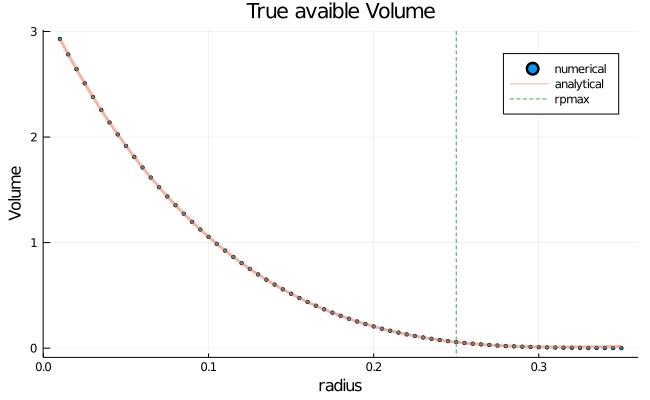

In [6]:
scatter(rs, numerical_V_tot, yerror = 2 .* sigma_V_data, markersize=2, 
    lab="numerical", xlabel="radius", ylabel ="Volume")
plot!(rs, exact_V_tot, lab="analytical", lw=3, alpha=0.5, size=(650, 400))
vline!([rpmax], ls=:dash, label="rpmax")
title!("True avaible Volume")

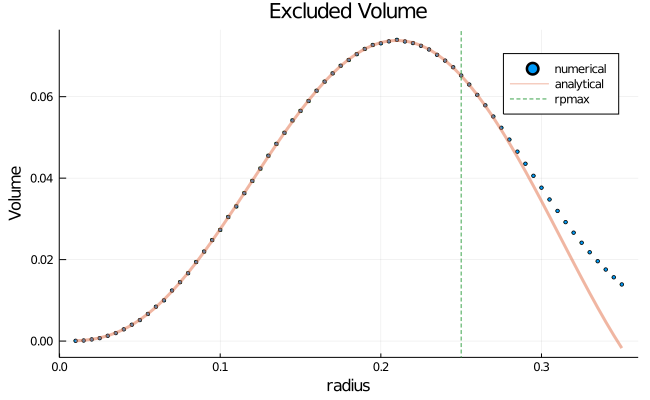

In [7]:
scatter(rs, numerical_V_neg, yerror = 2 .* sigma_V_data, markersize=2, 
    lab="numerical", xlabel="radius", ylabel ="Volume")
plot!(rs, exact_V_neg, lab="analytical", lw=3, alpha=0.5, size=(650, 400))
vline!([rpmax], ls=:dash, label="rpmax")
title!("Excluded Volume")

So, the above graphics show that there is no error in the Volume Calculations. The Curve begins to differ after the discontinuity limit for the derivatives. Everything seems to be nice and correct. Let us proceed to the Areas.

## Areas for the Events Cross Sections.

We shall procede in the same manner as before, splitting the negative part from the positive part. In one particular case this doesn't make sense and we shall begin with it. It is the collision of two balls. It occurs just in the border between excluded and permited configurations.

### Area for the Collisions of the Balls

The area that represents collitions  is given by
$$
  A_{col}=64 \sqrt{2} ( 2 \pi r^2 a_1a_2a_3 -  \pi r^3 (a_1a_2 +a_2a_3 + a_3 a_1)
  +4r^4/3 (a_1+a_2+a_3)
  -r^5/2)
  $$

In [9]:
""" Analytical Area for Collitions 3D """

function area_col3D(a,b,c,r)
    # asumiendo r<rhopmax
    result= 64 * sr2*  (2 * π * r^2 * a * b *c 
                - r^3 * π * (a*b+b*c+c*a)
                + 4 * r ^4 / 3* (a+b+c)
                -r^5/2)
    return (result, 0)
    
end 

""" Area for collitions Monte Carlo"""

function MC_collision_area3D(a, b, c, r, N=10^7, ϵ=1e-3)
    
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        ρ = √( (x1 - x2)^2 + (y1 - y2)^2 + (z1 - z2)^2)
        
        if  0 < ρ - 2r < (ϵ) *  √(2) # Corrected for shrewdness
            valid += 1
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    vbox=volPos(a,b,c)
    fuchi=0
    
    return ( vbox * p) / ϵ, fuchi, ((vbox * σ) / ϵ )
end


MC_collision_area3D (generic function with 3 methods)

In [10]:
rs_C, num_C_data, fake1, sigma_C_data, exact_C_data, fake2 = run_MC(MC_collision_area3D, area_col3D, rpmax, 10^7);

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

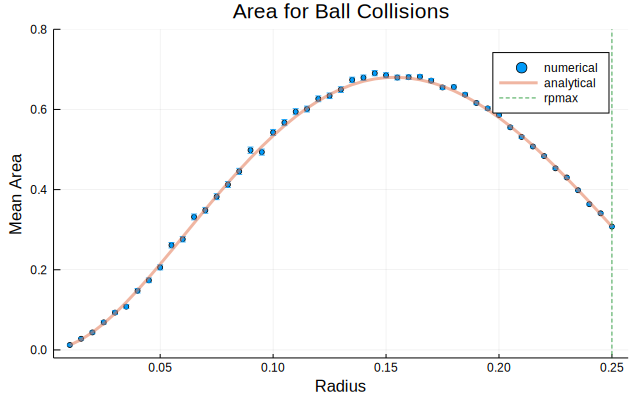

In [11]:
scatter(rs_C, num_C_data, yerror=sigma_C_data, markersize=3, lab="numerical", ylim=(-0.02,0.8))
plot!(rs_C, exact_C_data, lab="analytical", lw=3, alpha=0.5, size=(640, 400))
xlabel!("Radius")
ylabel!("Mean Area")
vline!([rpmax], label="rpmax", ls=:dash)
title!("Area for Ball Collisions")

Well, those two ( Volume and Area) seem to fit pretty nicely to the teorical result. As it will be seen below, they are also the ones that better agree with the dynamics. But now for the problematic ones.

## One ball hits one  wall

The area for one ball hitting one wall is 

$$
A_{HIT}=A_{FC}-A_{WC} 
$$
where
$$
A_{FC}=32 a_3 a_1^2 a_2^2 \\
    A_{WC}= 64 \pi a_1 a_2 r^3 - 4\pi r^4 (a_1 +a_2) + 65/15 r^5.
$$
  where $a_1, a_2$ are the dimensions that border  the wall, and the wall is perpendicular to $a_3$. That is, if the wall is in perpendicular to the $x$ axis, then $a_1, a_2$ are $b,c$ in the agreed notation. The functions below can be used for other colisions with walls by interchanging indexes. Below is the function for Ball 1 hitting the upper wall.

In [12]:
" It hits the h3 or c wall (the third wall)"
function area_wall3D(a, b, c, r)
    
    partepositiva= 32 * c * a^2 * b^2
    partenegativa= (64 * pi * (a * b ) * r^3/3 
                    - 8 * pi * ( a + b) * r^4 
                    + 128/15 * r ^5)
    #-pi/4 * r^4 * (a + b) 
    #2/3 * r^3 * a * b 
    #+4/15 * r^5  +pi/4 * r^4 * (a + b) 
    
    result = partepositiva - partenegativa #probemos negativa sola primero
    #result = partenegativa
    
    return (result, partenegativa)
end

""" Area for hitting the third wall on 3D---- that is the h3 or c direction """

function MC_wall_area3D(a, b, c, r, N=10^7, ϵ=1e-3)
        
    validtrue = 0
    validneg=0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        if c - ϵ < z1 < c
            if  (x1 - x2)^2 + (y1 - y2)^2 + (z1 - z2)^2 > (2*r)^2   # overlapping condition for testing
           # collision of disc 1 with upper
                validtrue += 1
            else
                validneg += 1
            end
        end
  
    
    end
    
    p = validtrue / N
    pneg= validneg /N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    
    
    vbox=volPos(a,b,c)
    
    return ( vbox * p / ϵ, (vbox * pneg) / ϵ,  (vbox * σ) / ϵ )
end


MC_wall_area3D (generic function with 3 methods)

In [13]:
rs_W, num_W_tot, num_W_neg, sigma_W_data, exact_W_tot, exact_W_neg = run_MC(MC_wall_area3D, 
    area_wall3D, rpmax, 10^7);

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

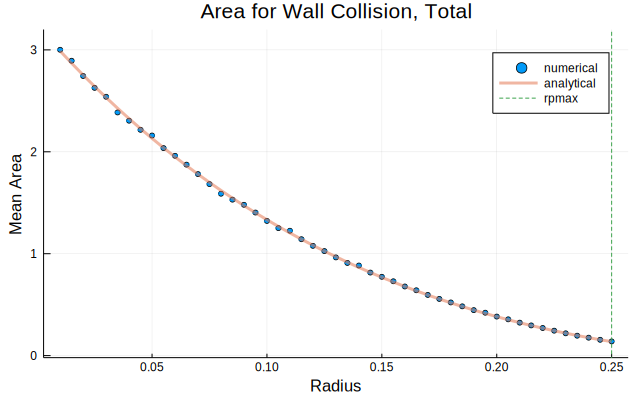

In [14]:
scatter(rs_W, num_W_tot, yerror=sigma_C_data, markersize=3, lab="numerical", ylim=(-0.02,3.2))
plot!(rs_W, exact_W_tot, lab="analytical", lw=3, alpha=0.5, size=(640, 400))
xlabel!("Radius")
ylabel!("Mean Area")
vline!([rpmax], label="rpmax", ls=:dash)
title!("Area for Wall Collision, Total")

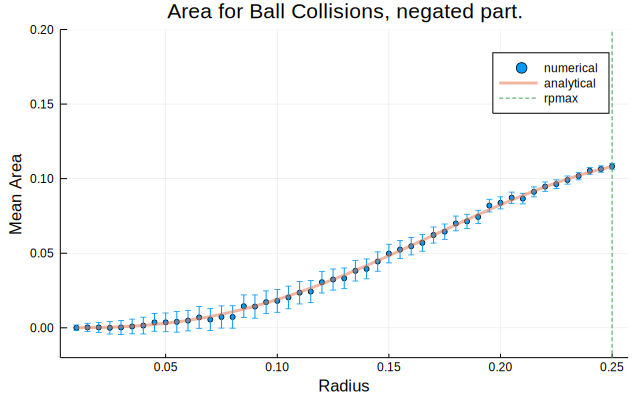

In [15]:
scatter(rs_W, num_W_neg, yerror=sigma_C_data, markersize=3, lab="numerical", ylim=(-0.02,0.2))
plot!(rs_W, exact_W_neg, lab="analytical", lw=3, alpha=0.5, size=(640, 400))
xlabel!("Radius")
ylabel!("Mean Area")
vline!([rpmax], label="rpmax", ls=:dash)
title!("Area for Ball Collisions, negated part.")

They look nice, don't they? Let us verify the last one before moving to the dynamics.

###   Hopping Area 

The hopping Area  in n Dimensions turned to be given by the next beautifull expression:

$$A_{hop,n}  =  2^{2n-1}\sqrt{2}a_1\prod_{j=2}^n a_j^2-A_{exc,n} \\
      =  2 \sqrt{2}a_1 (V_{tot,n-1} - V_{exc,n-1})$$


That is, the Hopping Area is the efective volume of the n-1 dimensional box, using the dimensions not along the hop. We shall check hops in the x-axis direction.

In [16]:
""" Explore hops along the first (a or h1 or x) dimension """ 

function MC_horiz_hop_area3D(a, b, c, r, N=10^7, ϵ=0.001)
    
    validtot = 0
    validneg = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        if abs(x1 - x2) < (ϵ * √2)  # horizontal hopping condition; factor √2 from diagonal orientation
            if (x1 - x2)^2 + (y1 - y2)^2 + (z1-z2)^2 > (2r)^2   # overlapping for testing first
                validtot += 1
            else
                validneg +=1
            end
        end
    end
    
    p = validtot / N
    pneg = validneg / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    vbox=volPos(a,b,c)
    
    return ( vbox * p / (2ϵ), vbox*pneg/(2ϵ),(vbox  * σ) / (2ϵ) )   # factor of 2 since area is "2-sided"
end

function area_horiz_hop3D(a, b, c, r)
    vnegbc=16*pi*b*c*r^2-64/3*(b+c)*r^3+8*r^4
    vposbc=16*b^2*c^2
      result=(vposbc-vnegbc)
    #result= 2 *sr2* a* (vposbc-vnegbc)
    # dado que los volumenes son pequeños, primero exploramos lo negativo
    # result= 2 *sr2* a* vnegbc
    return a*sr2*2*result, a*sr2*2*vnegbc
end



area_horiz_hop3D (generic function with 1 method)

In [17]:
rs_H, num_H_tot, num_H_neg, sigma_H_data, exact_H_tot, exact_H_neg = run_MC(MC_horiz_hop_area3D, 
    area_horiz_hop3D, rpmax, 10^7);

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

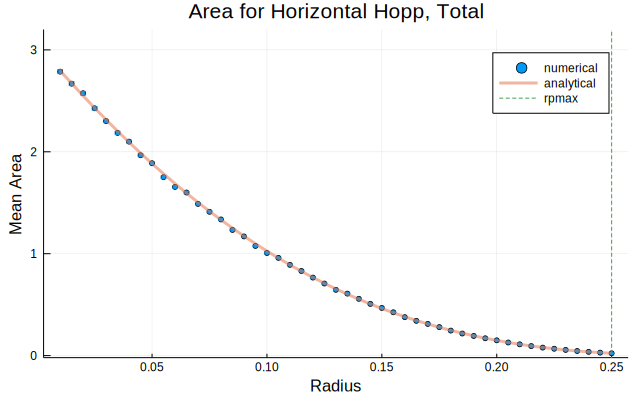

In [18]:
scatter(rs_H, num_H_tot, yerror=sigma_H_data, markersize=3, lab="numerical", ylim=(-0.02,3.2))
plot!(rs_H, exact_H_tot, lab="analytical", lw=3, alpha=0.5, size=(640, 400))
xlabel!("Radius")
ylabel!("Mean Area")
vline!([rpmax], label="rpmax", ls=:dash)
title!("Area for Horizontal Hopp, Total")

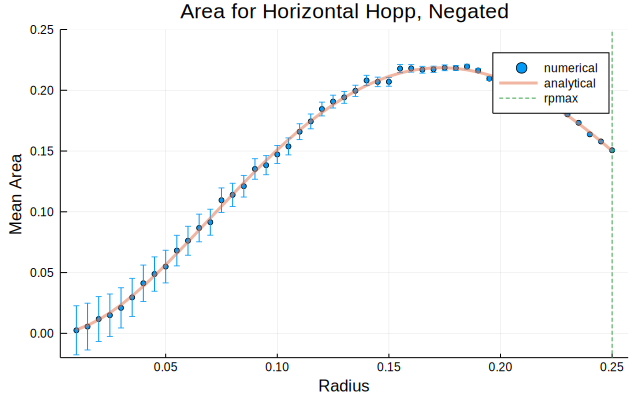

In [19]:
scatter(rs_H, num_H_neg, yerror=sigma_H_data, markersize=3, lab="numerical", ylim=(-0.02,0.25))
plot!(rs_H, exact_H_neg, lab="analytical", lw=3, alpha=0.5, size=(640, 400))
xlabel!("Radius")
ylabel!("Mean Area")
vline!([rpmax], label="rpmax", ls=:dash)
title!("Area for Horizontal Hopp, Negated")

So far, so good. Let us proceed to the Dynamics

## Dynamics and the Machta-Zwanzig Mistery Formula

I shall put all code here, so that it is easier to correct and to read and inspect for humans like you.
In the nexts cells is my modification of the routines by David.

In [23]:
using Distributions, LinearAlgebra

In [24]:
normsq(v) = sum(abs2, v)

normsq (generic function with 1 method)

In [42]:
"""
Generate initial condition for two spheres with radii r1 and r2,
in a box of size 2a*2b*2c.
Returns positions first disc, velocity first disc, positions second disc
velocities second disc
"""

function initial_condition(h1, h2, h3, r)

    a = h1/2 - r
    b = h2/2 - r
    c = h3/2 - r

   # print(" ea r ini ", r, " ")
    # TODO: Add check for max number of tries to place discs

    # position:
    x1, x2 = rand(Uniform(-a, a), 2)
    y1, y2 = rand(Uniform(-b, b), 2)
    z1, z2 = rand(Uniform(-c, c), 2)
    distsq = normsq([x1-x2, y1-y2, z1-z2])

   
    n=0
    # repeat until right, more common with more dimensions.
    while distsq <= (2r)^2

        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        distsq = normsq([x1-x2, y1-y2, z1-z2])
        n+=1
    end
    
    ## generate velocities whose sum squared is 1 by rejection method
    v = ones(6)

    while normsq(v) > 1
        v = rand(Uniform(-1.0, 1.0), 6)
    end

    ## normalize is now on LinearAlgebra
    normalize!(v)  # sum squared is 1

    return [x1, y1, z1], v[1:3], [x2, y2, z2], v[4:6]

end


#initial_condition(a, b, r) = initial_condition(a, b, r, r)

initial_condition (generic function with 1 method)

In [43]:
"""
Simulate the collision of two discs of radii r1 and r2
in the box [-w/2, w/2] × [-h/2, h/2]
"""
function dynamics(h1, h2, h3, r, num_collisions)

    t = 0.0

    times_data = Float64[]
    position_data = Vector{Float64}[]
    velocity_data = Vector{Float64}[]
    collision_type_data = Int[]

#    print(" ea r dynamics yeah  ", r, " ")
    
    x1, v1, x2, v2 = initial_condition(h1, h2, h3, r)
    x = vcat(x1, x2)  # all position coords of both discs
    v = vcat(v1, v2)  # all velocity coords

    # Code for wall collisions (in variable which):
    # 1, 2, 3, correspond to first disc colliding with positive h1,h2, h3 direction.
    # 4, 5, 6, correspond to second disc colliding with positive h1,h2, h3 direction.
    # negative correspond to negative direction walls
    # 7 corresponds to two discs colliding

    # set up arrays so that all wall collisions achieved
    # point particle at centre of disc collides with wall moved by radius

    

    a = h1/2 - r
    b = h2/2 - r
    c = h3/2 - r
    
    high_walls = [ a,  b,  c,  a,  b, c]
    low_walls =  [-a, -b, -c,  -a, -b, -c]

    collision_times = zeros(7)

    which = 17  # which obstacle whichly hit

	for n in 1:num_collisions

        # find wall collision times:
        # for each component of each disc, check for collisions with both walls:

        # (c - x) / v  is the time to collide with wall at c in that direction

        for i in 1:6

	    t1 = (low_walls[i] - x[i]) / v[i]  # wall at positive direction
	    t2 = (high_walls[i] - x[i]) / v[i]  # wall at opposite position
	    collision_times[i] = max(t1, t2) # just one time is positive

        end


		# find disc collision time:
        # TODO: Use StaticArrays?

    Δx = x1 - x2
    Δv = v1 - v2

        # chicharronera, David please do not repeat variables for completely other
        # things
	ach = Δv⋅Δv
	bch = 2 * Δx⋅Δv
	cch = normsq(Δx) - (2r)^2
           
        discriminant = bch^2 - 4*ach*cch

        collision_times[7] = Inf  # assume no collision

        # the condition `which != 5` excludes the sphere from consideration if was hit at previous step
     
            
	if discriminant >= 0 && which != 7
	    d = √discriminant

            t1 = (-bch + d) / (2*ach)
            t2 = (-bch - d) / (2*ach)
          
            
	    if t1 > 0
		if t2 > 0
		    collision_times[7] = min(t1, t2)
		else
		    collision_times[7] = t1
                end
            end
            
        end
            

	min_time, which = findmin(collision_times)

        t += min_time
	x += v * min_time


	# implement collision:
	if which == 7  # collision of two discs           
            # interchange the velocitie components along Delta x
            # that is, the vector joining their centers.
            
            vp1 = ((v1 ⋅ Δx) / normsq(Δx)) * Δx
	    vn1 = v1 - vp1

            vp2 = ((v2 ⋅ Δx) / normsq(Δx)) * Δx
	    vn2 = v2 - vp2

            
	    v[1:3] = vn1 + vp2
	    v[4:6] = vn2 + vp1

        else
	    v[which] = -v[which]  # reflect off hard wall

            if x[which] < 0
                which = -which  # indicate which wall collided with using negative sign for low walls
            end

        end

        x1=x[1:3]
        x2=x[4:6]
        v1=v[1:3]
        v2=v[4:6]    
            
        push!(position_data, copy(x))
        push!(velocity_data, copy(v))
        push!(times_data, t)
        push!(collision_type_data, which)

    end # for n collitions

    return times_data, position_data, velocity_data, collision_type_data
end

dynamics

In [44]:
"""
Calculate the times at which  hops occur in 3D (First Axis per default)
"""
function hopping_times(times, positions, velocities; dimax=1)
    # dimax specifies which axis, 1 ("x"), 2 ("y"), 3, ("z")
    Δxs = [x[dimax+3] - x[dimax] for x in positions]  # x_2 - x_1
    Δus = [v[dimax+3] - v[dimax] for v in velocities]  # u_2 - u_1;
    
    # indices where there is a hop between collisions i and i+1: 
    hop_indices = findall(i->sign(Δxs[i]) != sign(Δxs[i+1]),1:(length(positions)-1) );  
    
    # x + t*u = 0   so   t = -x/u
    hopping_times = times[hop_indices.+1] - (Δxs[hop_indices] ./ Δus[hop_indices])
    
    return hopping_times
end
## Verified by karel, it is correct.
 


hopping_times

Now, let us make some sanity tests.

In [45]:
r=0.1762
@time times, positions, velocities, collision_types = dynamics(h1,h2,h3, r, 30000);

  0.225546 seconds (589.85 k allocations: 52.656 MiB)


In [46]:
println(norm.(velocities)[1000:1050]) #Sanity Check ....

[0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.999999999999999, 0.9999999999999989, 0.9999999999999989, 0.9999999999999989, 0.9999999999999989, 0.9999999999999989]


In [47]:
println(collision_types[1000:1050])#Sanity Check

[-6, 4, 3, 5, -1, -2, -4, 7, 1, -6, -1, 4, 5, 1, 6, 7, -1, -2, 1, 5, -1, -4, 1, 2, -1, -3, 1, -2, -1, 7, 4, -4, 5, 4, -2, -4, 4, 6, -4, -3, -5, 4, -4, 4, 5, -4, 7, 1, -2, 4, 5]


Now, for the expressions that define the Machta Zwanzig's things.

In [48]:
cte=π * 15/8  #E=1/2, -> abs(v^2)=1 as above
# In this notebook all analytical formulas spit out two results, the total and the "negative"
# slightl modifications to take that into account.!

horiz_hop_analytical(a,b, c, r)=cte*vol(a,b,c, r)[1]/area_horiz_hop3D(a,b,c,r)[1]
upper_wall_analytical(a,b,c,r)=cte*vol(a,b,c,r)[1]/area_wall3D(a,b,c,r)[1]
disc_collision_analytical(a,b,c,r)=cte*vol(a,b,c,r)[1]/area_col3D(a,b,c,r)[1]

disc_collision_analytical (generic function with 1 method)

In [49]:
function simulation(h1, h2, h3, num_collisions=10^3, rango=0.005:0.005:rfin)
    
    num_horiz_hop_data=Float64[]
    exact_horiz_hop_data=Float64[]
        
    num_disc_collision_data = Float64[]
    exact_disc_collision_data = Float64[]
    
    num_upwall_data = Float64[]
    exact_upwall_data = Float64[]
    

    
    for r in rango
        print(r, " ")
        flush(stdout)
        
        a = h1/2 - r
        b = h2/2 - r
        c = h3/2 -r
        
        
        times, positions, velocities, collision_types = dynamics(h1, h2, h3, r, num_collisions);
        
        
        horiz_hopping_times = hopping_times(times, positions, velocities, dimax=1)

        push!(num_horiz_hop_data, mean(diff(horiz_hopping_times)))   # diff gives inter-hop times
        push!(exact_horiz_hop_data, horiz_hop_analytical(a, b, c,  r))
        
        disc_collision_times = times[collision_types .== 7]
        push!(num_disc_collision_data, mean(diff(disc_collision_times)))   # diff gives inter-hop times
        push!(exact_disc_collision_data, disc_collision_analytical(a, b, c, r))
       
        upwall_times = times[collision_types .== -6]
        push!(num_upwall_data, mean(diff(upwall_times)))   # diff gives inter-hop times
        push!(exact_upwall_data, upper_wall_analytical(a, b,c, r))
        
    end
    
    return (num_horiz_hop_data, exact_horiz_hop_data, num_disc_collision_data, 
        exact_disc_collision_data, num_upwall_data, exact_upwall_data)
                
end

simulation (generic function with 3 methods)

In [51]:
nevents=5*10^6
rango=0.01:0.01:0.25
@time (num_horiz_hop_data, exact_horiz_hop_data, num_disc_collision_data, 
    exact_disc_collision_data, num_upwall_data, exact_upwalldata)= simulation(h1, h2, h3, nevents, rango);

0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 277.552587 seconds (1.42 G allocations: 165.428 GiB, 50.02% gc time)


In [52]:
using JLD # To save the data, and save us headeaches

save("DatosNumericos3D_5e6.jld", "rango", rango, 
    "num_horiz_hop_data", num_horiz_hop_data,
    "num_disc_collision_data", num_disc_collision_data,
    "num_upwall_data", num_upwall_data
)

Now we procede to plot. The best agreement is the one for the discs colliding against each other.

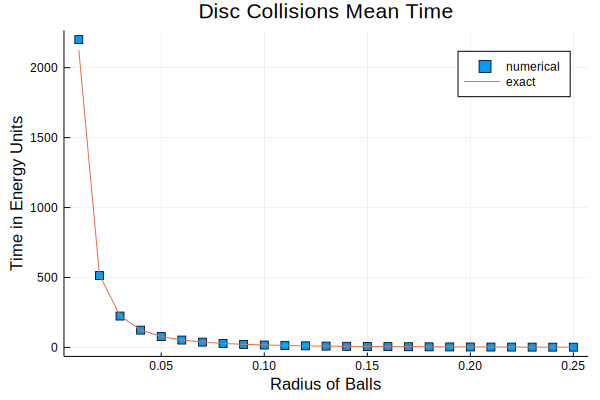

In [54]:
Plots.scatter(rango, num_disc_collision_data, m=:square, label="numerical")
plot!(rango, exact_disc_collision_data, label="exact")
title!("Disc Collisions Mean Time")
xlabel!("Radius of Balls")
ylabel!("Time in Energy Units")

Perfect, isn't it??!!!, well you can even put it in log scale or anything. Agreement could not be better. What a start!! Now then it comes the surprises. Let us check the wall hit times.

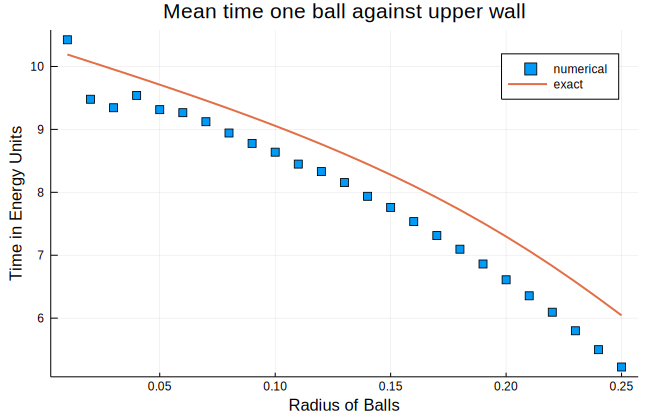

In [61]:
guessfactor=1
scatter(rango, num_upwall_data.*guessfactor, m=:square, label="numerical", size=(650,420))
plot!(rango, exact_upwalldata, label="exact", linewidth=2) #absolut PERFECT
title!("Mean time one ball against upper wall")
xlabel!("Radius of Balls")
ylabel!("Time in Energy Units")

Did we miss some goddamned factor of $\sqrt{2}$ ? No, that is not it. You can check it by multiplyng the lines by your best guess factor. It is something that seems to go like $r^{-1}$, but not exactly that...
Remember that the Volume and Area look very nicely on the MonteCarlo Calculations!

Finally, the dastarly hopping times... I do not know what to make of this...

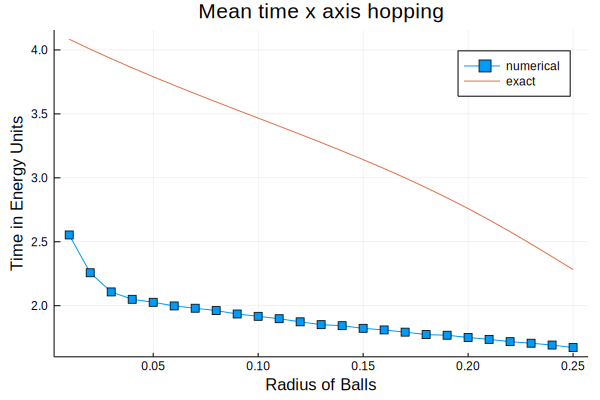

In [62]:
plot(rango, num_horiz_hop_data, m=:square, label="numerical")
plot!(rango, exact_horiz_hop_data, label="exact") 
title!("Mean time x axis hopping")
xlabel!("Radius of Balls")
ylabel!("Time in Energy Units")

One observation though: Both seem to go to shorter times as r grows. This may look conterintuitive on first sight, but the x axis is the shorter one. So, when the balls are really big, they have problems interchanging positions in all directions, but are more constrained by the x axis length to keep both their y and z positions, and they bounce back and forth between the walls at $-a$ and $a$, so at least that is correct.